In [127]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import glob


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)
import numpy as np
from mne.preprocessing import ICA

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
files = glob.glob('../files/S001/*.edf')

In [3]:
len(files)

14

In [85]:
'''
https://github.com/mne-tools/mne-python/blob/main/mne/datasets/eegbci/eegbci.py#L110
=========  ===================================
run        task
=========  ===================================
1          Baseline, eyes open
2          Baseline, eyes closed
3, 7, 11   Motor execution: left vs right hand
4, 8, 12   Motor imagery: left vs right hand
5, 9, 13   Motor execution: hands vs feet
6, 10, 14  Motor imagery: hands vs feet
=========  ===================================
'''
raws = []
f = [5,9,13]
# ,6,10,14]
for i in f:
    print(i)
    current_file = files[i-1]
    r = read_raw_edf(current_file, preload=True, stim_channel='auto')
    events, _ = mne.events_from_annotations(r)
    if i in [5, 9, 13]:
        new_labels_events = {1:'rest', 2:'action_hand', 3:'action_feet'} # action
    else:
        new_labels_events = {1:'rest', 2:'imagine_hand', 3:'imagine_feet'} # imagine
    new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, sfreq=r.info['sfreq'], orig_time=r.info['meas_date'])
    r.set_annotations(new_annot)
    raws.append(r)
    
raw_obj = concatenate_raws(raws)

5
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
9
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
13
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)



Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Used Annotations descriptions: ['action_feet', 'action_hand', 'rest']
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
{'action_feet': 1, 'action_hand': 2, 'rest': 3}
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.6s.


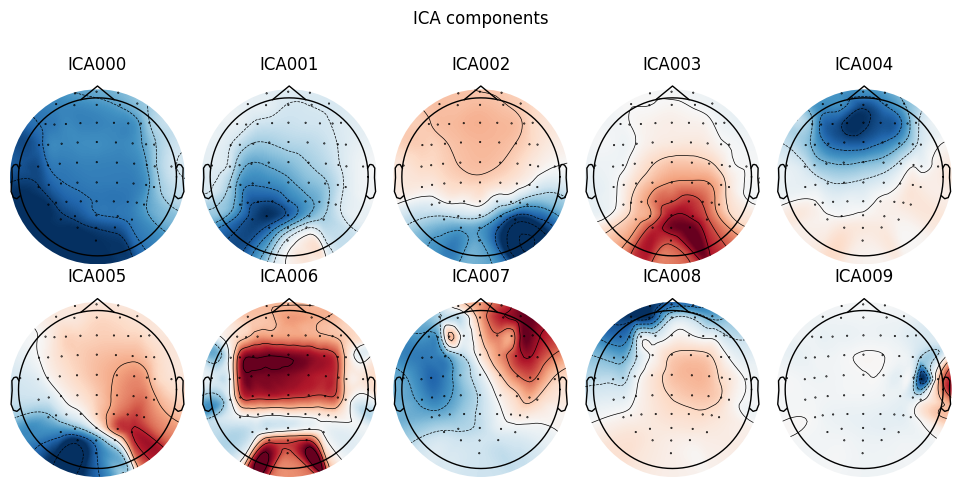

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Used Annotations descriptions: ['action_feet', 'action_hand']


/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


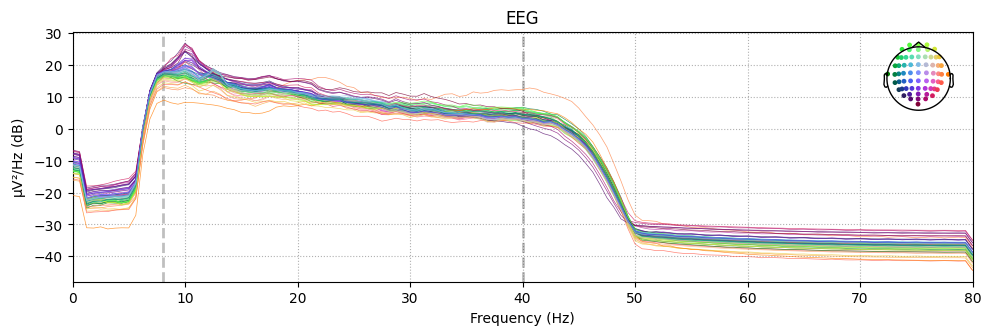

In [99]:
original_raw = raw_obj.copy()

# filters
notch_freq = 60
original_raw.notch_filter(notch_freq, fir_design='firwin')

low_cutoff = 8
high_cutoff = 40
original_raw.filter(low_cutoff, high_cutoff, fir_design='firwin')


events, event_dict = mne.events_from_annotations(original_raw)
print(original_raw.info)
print(event_dict)
picks = mne.pick_types(original_raw.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
eegbci.standardize(original_raw)
montage = mne.channels.make_standard_montage('standard_1005')
original_raw.set_montage(montage)

## ICA
n_components = 10
ica = ICA(n_components=n_components, random_state=97, max_iter=800)
ica.fit(original_raw)
ica.plot_components()
components_to_excludes, scores = ica.find_bads_eog(original_raw, ch_name='Fpz')
if components_to_excludes is not None and len(components_to_excludes) > 0:
    ica.plot_properties(original_raw, picks=components_to_excludes)
else:
    print("No components to exclude")
original_raw.compute_psd().plot()

event_id = {'action_hand': 1, 'action_feet': 2}
events, event_dict = mne.events_from_annotations(original_raw, event_id=event_id)
print(picks)

In [100]:
tmin = -0.5  # Time before event in seconds
tmax = 4.  # Time after event in seconds
epochs = mne.Epochs(original_raw, events, event_dict, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
print(epochs)
print(epochs.events[:, -1] - 1)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 721 original time points ...
0 bad epochs dropped
<Epochs |  30 events (all good), -0.5 - 4 sec, baseline off, ~10.7 MB, data loaded,
 'action_feet': 16
 'action_hand': 14>
[0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1]


In [139]:

# _, event_dict = mne.events_from_annotations(original_raw)
# print(event_dict)

X = epochs.get_data()
y = epochs.events[:, -1] - 1

print(X.shape)
print(y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

models = [
    # ('Gradient Boosting', GradientBoostingClassifier(), {'model__n_estimators': [50, 100]}),
    ('Linear discriminant analysis', LinearDiscriminantAnalysis(), {'model__solver': ['svd', 'lsqr', 'eigen'], 'model__tol': [0.0001, 0.00001]}),   
    # ('SVM', SVC(), {'model__C': [0.5, 1, 3], 'model__kernel': ['linear']}),
    # ('KNN', KNeighborsClassifier(), {'model__n_neighbors': [4,5,6]}),
    # ('Random Forest', RandomForestClassifier(), {'model__n_estimators': [50,100]}),
    # ('MLP', MLPClassifier(), {'model__hidden_layer_sizes': [(100, 50), (200, 100)]}),
    # ('Decision Tree', DecisionTreeClassifier(), {'model__max_depth': [50, 100]}),
    # ('XGB', XGBClassifier(), {'model__n_estimators': [200, 300], 'model__learning_rate': [0.05, 0.001]})
]

pipelines = []
csp = CSP()
for name, model, param_grid in models:
    pipeline = Pipeline([
        ('csp', csp),
        ('model', model)
    ])
    param_grid['csp__n_components'] = [5, 6, 7, 8, 9, 10, 15, 20, 30, 40]
    pipelines.append((name, pipeline, param_grid))

(30, 64, 721)
(30,)


In [140]:
%%capture
results = []
for name, pipeline, param_grid in pipelines:
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=shuffle_split, n_jobs=-1)
    # scores = cross_val_score(grid_search, X, y, cv=shuffle_split, scoring='accuracy')
    grid_search.fit(X, y)
    results.append((name, grid_search))

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 64
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data chan

In [141]:
res_grid = []
for name, grid_search in results:
    res_grid.append({'name': name, 'scores_mean': scores.mean(), 'scores_std': scores.std(), 'best_params_': grid_search.best_params_, 'best_score_': grid_search.best_score_})
    print(f"Model: {name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.2f}")
    print("\n")

Model: Linear discriminant analysis
Best Parameters: {'csp__n_components': 5, 'model__solver': 'svd', 'model__tol': 0.0001}
Best Cross-Validated Accuracy: 0.87




In [62]:
import json

with open('f.json', 'w+') as f:
    json.dump(res_grid, f)